In [3]:


import importlib
import keras
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import layers
from keras import ops
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tensorflow as tf

os.environ["KERAS_BACKEND"] = "tensorflow"
sys.path.append("../../")

from astroLuSt.datascience import (
    layers as aldala,
    totables as aldato
)
from astroLuSt.styles import plot_styles as alstps

importlib.reload(alstps)

#style for plotting
_ = alstps.tre_light()

# `hypergrid2latex()`
* Convert Hyperparameter Grid to Latex

In [4]:
hypgrid = dict(
    epochs=100,
    learning_rate=1e-3,
    intermediate_dim=512,
    latent_dim=2,
    beta_1=0.9,
    beta_2=0.999,
    clipnorm=1.0,
)

hypgrid_ltx = aldato.hypergrid2latex(hypergrid=hypgrid)
print(hypgrid_ltx)

\begin{table}[!th]
\caption{Hyperparameter-Grid}
\label{tab:YOURLABEL}
\begin{tabular}{ll}
\toprule
Parameter & Value \\
\midrule
epochs & 100.0 \\
learning_rate & 0.001 \\
intermediate_dim & 512.0 \\
latent_dim & 2.0 \\
beta_1 & 0.9 \\
beta_2 & 0.999 \\
clipnorm & 1.0 \\
\bottomrule
\end{tabular}
\end{table}



# `summary2pandas_keras()`
* storing a `keras` model summary in a `pandas.DataFrame`

## Define a Model (VAE)
* following https://keras.io/examples/generative/vae/ except for custom `Sampling()` layer

### Build the encoder

In [5]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = aldala.Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
# encoder.summary()

### Build the decoder

In [6]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
# decoder.summary()

### Define the VAE as a `Model` with a custom `train_step`

In [7]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [8]:
#combine to VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

#train the model
##load the data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#rescale
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255

# #test plot
# fig = plt.figure()
# plt.imshow(X_train[0])
# plt.show()

#reshape to 1d
n2use = 10000
X_train = np.expand_dims(X_train, -1)[:n2use]
X_test = np.expand_dims(X_test, -1)[:n2use]
y_train = y_train[:n2use]
y_test = y_test[:n2use]
print(X_train.shape, X_test.shape)

hist = vae.fit(
    X_train, 
    epochs=30,
    batch_size=128,
    callbacks=None
)

(10000, 28, 28, 1) (10000, 28, 28, 1)
Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - kl_loss: 3.3688 - loss: 391.6131 - reconstruction_loss: 388.2443
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - kl_loss: 2.7423 - loss: 209.1493 - reconstruction_loss: 206.4071
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - kl_loss: 3.1262 - loss: 200.2981 - reconstruction_loss: 197.1719
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - kl_loss: 3.2540 - loss: 195.5623 - reconstruction_loss: 192.3083
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - kl_loss: 3.0747 - loss: 192.5855 - reconstruction_loss: 189.5108
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - kl_loss: 2.8971 - loss: 190.6864 - reconstruction_loss: 187.7892
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - kl_loss: 2.7652 - loss: 188.4458 - reconstruction_loss: 185.6805
Epoch 8/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - kl_loss: 2.7008 - loss: 186.5408 - reconstruction_loss: 183.8400
Epoch 9/30
79/79 ━

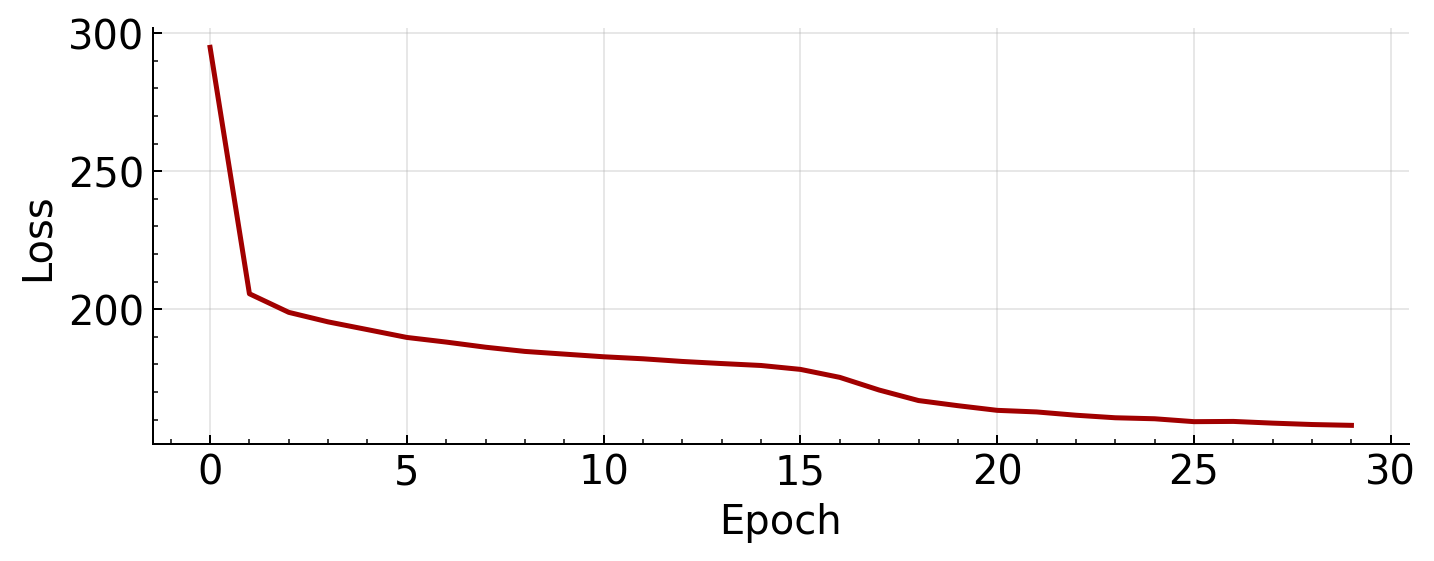

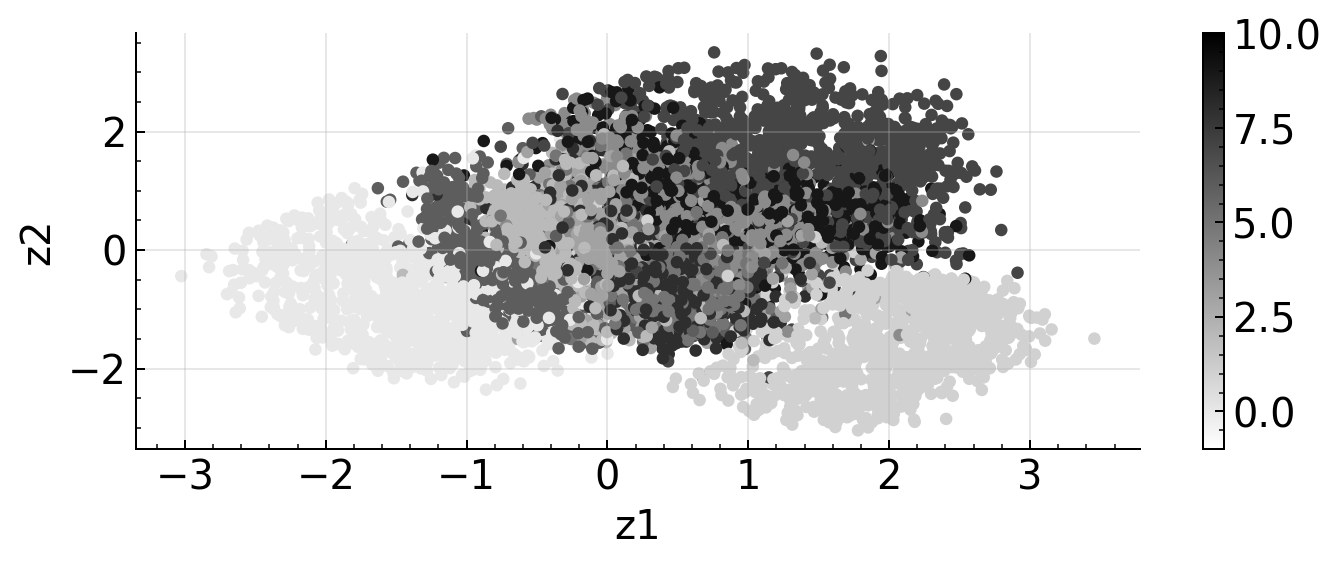

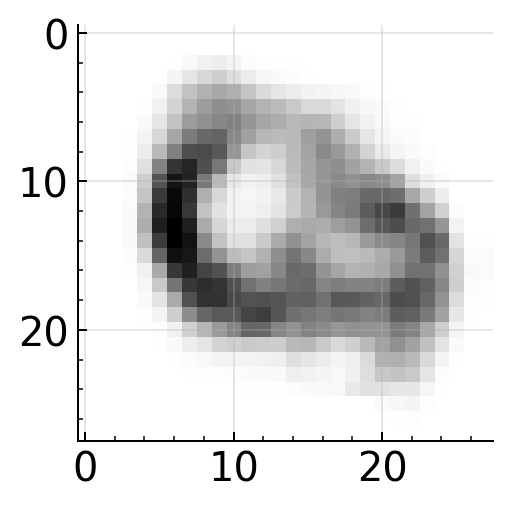

In [12]:
#visualize results
fig = plt.figure(figsize=(9,3))
ax1 = fig.add_subplot(111)
ax1.plot(hist.history["loss"])
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")


z_mu, z_log_var, z = encoder(X_train)

fig = plt.figure(figsize=(9,3))
ax1 = fig.add_subplot(111)
sctr = ax1.scatter(z[:,0], z[:,1], c=y_train, vmin=-1,vmax=10)
cbar = fig.colorbar(sctr, ax=ax1)
ax1.set_xlabel("z1")
ax1.set_ylabel("z2")

X_gen = decoder(tf.constant([[-1,2]]))
fig = plt.figure(figsize=(9,3))
ax1 = fig.add_subplot(111)
ax1.imshow(tf.reshape(X_gen[0], (28, 28)))
plt.show()

plt.show()

## Store Model Summary

In [13]:
importlib.reload(aldato)
df_sum_enc = aldato.summary2pandas_keras(
    model=encoder,
    layer_attrs=["units", "filters", "kernel_size"],
    verbose=0,
)
display(df_sum_enc)
df_sum_dec = aldato.summary2pandas_keras(
    model=decoder,
    layer_attrs=["units", "filters", "kernel_size"],
    verbose=0,
)
display(df_sum_dec)

,name,type,input_shape,output_shape,activation,trainable_params,non_trainable_params,total_params,units,filters,kernel_size
0,input_layer,InputLayer,,"(None, 28, 28, 1)",None,0,0,0,NaN,NaN,None
1,conv2d,Conv2D,"(None, 28, 28, 1)","(None, 14, 14, 32)",relu,320,0,320,NaN,32.0,"(3, 3)"
2,conv2d_1,Conv2D,"(None, 14, 14, 32)","(None, 7, 7, 64)",relu,18496,0,18496,NaN,64.0,"(3, 3)"
3,flatten,Flatten,"(None, 7, 7, 64)","(None, 3136)",None,0,0,0,NaN,NaN,None
4,dense,Dense,"(None, 3136)","(None, 16)",relu,50192,0,50192,16.0,NaN,None
5,z_mean,Dense,"(None, 16)","(None, 2)",linear,34,0,34,2.0,NaN,None
6,z_log_var,Dense,"(None, 16)","(None, 2)",linear,34,0,34,2.0,NaN,None
7,sampling,Sampling,,"(None, 2)",None,0,0,0,NaN,NaN,None


,name,type,input_shape,output_shape,activation,trainable_params,non_trainable_params,total_params,units,filters,kernel_size
0,input_layer_1,InputLayer,,"(None, 2)",None,0,0,0,NaN,NaN,None
1,dense_1,Dense,"(None, 2)","(None, 3136)",relu,9408,0,9408,3136.0,NaN,None
2,reshape,Reshape,"(None, 3136)","(None, 7, 7, 64)",None,0,0,0,NaN,NaN,None
3,conv2d_transpose,Conv2DTranspose,"(None, 7, 7, 64)","(None, 14, 14, 64)",relu,36928,0,36928,NaN,64.0,"(3, 3)"
4,conv2d_transpose_1,Conv2DTranspose,"(None, 14, 14, 64)","(None, 28, 28, 32)",relu,18464,0,18464,NaN,32.0,"(3, 3)"
5,conv2d_transpose_2,Conv2DTranspose,"(None, 28, 28, 32)","(None, 28, 28, 1)",sigmoid,289,0,289,NaN,1.0,"(3, 3)"
